In [1]:
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import aplpy

from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/process_tools")
from cut_resize_tools import *
from Astronomy import *

In [2]:
fits_path = "/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"
integ_hdu = fits.open("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/processed_fits/CygnusX_sp16_120-230_integrate_map.fits")[0]

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]
wcs = WCS(integ_hdu.header)

raw_d = hdu.data
header = hdu.header

In [3]:
vsmooth = 5
thresh = 1
sigma = 2
sch_rms = 10
ech_rms = 90
sch_ii = 1
ech_ii = 320
percentile = 99.997
sigma_multiply = None
# width = 60

cut_size_list = [256, 128, 64]
integrate_layer_num = 30
obj_size = 100
maximum_mode = "percentile"

In [4]:
catalogue_path = '/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/cygnus_infer_catalogue.csv' # 提供されたCSVファイル
catalogue_data = pd.read_csv(catalogue_path)

In [5]:
def make_j2000_target_header(center_coord, fov_width_deg, fov_height_deg, pixel_scale_deg):
    """
    指定された中心と視野を持つ、J2000(RA/DEC)の2Dヘッダーを作成する関数
    """
    # 必要なピクセル数を計算
    npix_x = int(fov_width_deg / pixel_scale_deg)
    npix_y = int(fov_height_deg / pixel_scale_deg)

    # 新しいWCSオブジェクトを作成
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [npix_x / 2 + 0.5, npix_y / 2 + 0.5] # 中心ピクセル位置
    # ピクセルスケール (RA方向はマイナスにするのが通例)
    wcs.wcs.cdelt = np.array([-pixel_scale_deg, pixel_scale_deg])
    wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg] # 中心座標(RA, DEC)
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"] # 投影法 (TAN:gnomonic が一般的)
    wcs.wcs.equinox = 2000.0

    # ヘッダー情報に変換し、画像サイズを設定
    target_header = wcs.to_header()
    target_header['NAXIS1'] = npix_x
    target_header['NAXIS2'] = npix_y
    
    return target_header, (npix_y, npix_x)

In [6]:
# --- 元画像のピクセルスケールを推定 ---
# 出力画像のピクセルスケールを元画像と合わせるため。
# 簡易的にWCS情報から取得（正方形ピクセルと仮定）
try:
    # pixel_scale_matrix が使える場合
    input_pixel_scale_deg = np.mean(np.abs(w_high.pixel_scale_matrix.diagonal()))
except:
    # cdelt が直接使える場合（古いFITSなど）
    input_pixel_scale_deg = np.abs(w_high.wcs.cdelt[1])

print(f"Input pixel scale estimated: {input_pixel_scale_deg:.6f} deg/pix")


region_data_dic = {} # 結果を格納する辞書

print(f"Starting reprojection for {len(catalogue_data)} bubbles...")

Input pixel scale estimated: 83.334722 deg/pix
Starting reprojection for 78 bubbles...


In [8]:
cutting_ratio = 2

# --- メインループ ---
# CSVを直接ループして処理します
for index, row in catalogue_data.iterrows():
    # 1. バブルの中心とサイズ（RA/DEC）を定義
    ra_min, ra_max = row['ra_min'], row['ra_max']
    dec_min, dec_max = row['dec_min'], row['dec_max']

    # 中心座標
    center_ra = (ra_min + ra_max) / 2.0 * u.deg
    center_dec = (dec_min + dec_max) / 2.0 * u.deg
    center_coord = SkyCoord(ra=center_ra, dec=center_dec, frame='icrs')

    # 視野サイズ（バブルの幅/高さ * cutting_ratio）
    # RA方向の幅は、緯度(DEC)による歪みを考慮して補正
    width_ra_deg = (ra_max - ra_min) * np.cos(center_dec.to('rad').value)
    height_dec_deg = (dec_max - dec_min)
    
    # 切り抜く視野角を決定 (cutting_ratioを適用)
    fov_width = width_ra_deg * cutting_ratio
    fov_height = height_dec_deg * cutting_ratio
    
    # 少なくともある程度の大きさは確保する（オプション）
    # fov_width = max(fov_width, 0.1) # 例えば最小0.1度

    # 2. ターゲットとなるJ2000のヘッダーを作成
    target_header_2d, target_shape_2d = make_j2000_target_header(
        center_coord, fov_width, fov_height, input_pixel_scale_deg
    )

    print(f"Processing Bubble {index}: Center RA/DEC=({center_ra.value:.2f}, {center_dec.value:.2f}), Target Shape={target_shape_2d}")

    # 3. 再投影 (Reprojection) の実行
    # 入力が3Dデータ(V, Y, X)で、ターゲットヘッダーが2D(RA, DEC)の場合、
    # reproject_interp は自動的に速度軸(第1軸)に対してループ処理してくれます。
    try:
        output_cube, footprint = reproject_interp(
            (raw_d, header),    # 入力データとヘッダー
            target_header_2d,   # 目標とする2Dヘッダー
            shape_out=target_shape_2d # 目標とする2D形状 (これは省略可能だが明示しておくと安全)
        )
        
        # NaNの処理（元の画像の外側はNaNになるため、0埋め等が必要な場合）
        # output_cube = np.nan_to_num(output_cube, nan=0.0)

        # 結果を辞書に格納
        # キーは便宜上ID文字列にしています。
        bubble_id = f"bubble_{index:03d}"
        region_data_dic[bubble_id] = {
            'data': output_cube,
            'header_2d': target_header_2d, # 2D表示用ヘッダー
            'center_coord': center_coord
        }

    except Exception as e:
        print(f"Error processing bubble {index}: {e}")


# --- 確認用の図示 (例: 最初のバブルの速度積分図) ---
if len(region_data_dic) > 0:
    first_bubble_id = list(region_data_dic.keys())[0]
    data_cube = region_data_dic[first_bubble_id]['data']
    header_2d = region_data_dic[first_bubble_id]['header_2d']
    
    # 速度軸方向に積分して2D画像を作成
    moment0 = np.nansum(data_cube, axis=0)
    
    plt.figure(figsize=(8, 8))
    # aplpyを使ってJ2000座標で表示
    f = aplpy.FITSFigure((moment0, header_2d))
    f.show_colorscale(cmap='viridis')
    f.add_grid()
    f.set_title(f"{first_bubble_id} - J2000 North Up")
    # バブルの中心位置をマーク
    center = region_data_dic[first_bubble_id]['center_coord']
    f.show_markers(center.ra.deg, center.dec.deg, coords_frame='icrs', 
                   edgecolor='red', facecolor='none', marker='o', s=100, lw=2)
    plt.show()

print("Finished.")

Processing Bubble 0: Center RA/DEC=(308.82, 42.43), Target Shape=(0, 0)
Error processing bubble 0: Number of dimensions in input and output WCS should match
Processing Bubble 1: Center RA/DEC=(307.49, 40.82), Target Shape=(0, 0)
Error processing bubble 1: Number of dimensions in input and output WCS should match
Processing Bubble 2: Center RA/DEC=(308.08, 38.84), Target Shape=(0, 0)
Error processing bubble 2: Number of dimensions in input and output WCS should match
Processing Bubble 3: Center RA/DEC=(308.13, 40.27), Target Shape=(0, 0)
Error processing bubble 3: Number of dimensions in input and output WCS should match
Processing Bubble 4: Center RA/DEC=(306.85, 37.29), Target Shape=(0, 0)
Error processing bubble 4: Number of dimensions in input and output WCS should match
Processing Bubble 5: Center RA/DEC=(308.11, 38.86), Target Shape=(0, 0)
Error processing bubble 5: Number of dimensions in input and output WCS should match
Processing Bubble 6: Center RA/DEC=(305.20, 41.21), Target

Error processing bubble 32: Number of dimensions in input and output WCS should match
Processing Bubble 33: Center RA/DEC=(307.59, 43.02), Target Shape=(0, 0)
Error processing bubble 33: Number of dimensions in input and output WCS should match
Processing Bubble 34: Center RA/DEC=(304.51, 41.90), Target Shape=(0, 0)
Error processing bubble 34: Number of dimensions in input and output WCS should match
Processing Bubble 35: Center RA/DEC=(307.37, 39.06), Target Shape=(0, 0)
Error processing bubble 35: Number of dimensions in input and output WCS should match
Processing Bubble 36: Center RA/DEC=(305.18, 39.26), Target Shape=(0, 0)
Error processing bubble 36: Number of dimensions in input and output WCS should match
Processing Bubble 37: Center RA/DEC=(304.41, 39.36), Target Shape=(0, 0)
Error processing bubble 37: Number of dimensions in input and output WCS should match
Processing Bubble 38: Center RA/DEC=(305.22, 39.57), Target Shape=(0, 0)
Error processing bubble 38: Number of dimensio

In [20]:
glon_cygnus = fits.open("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/Cygnus-X/resultdir/hdu0_Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits")[0]

TypeError: Invalid shape (320, 1597, 2524) for image data

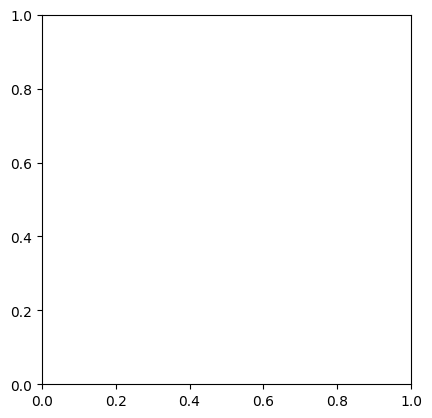

In [21]:
plt.imshow(glon_cygnus.data, vmin=0, vmax=5)

INFO: Auto-setting vmin to -1.290e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.459e+01 [aplpy.core]


KeyError: "Keyword 'BMAJ' not found."

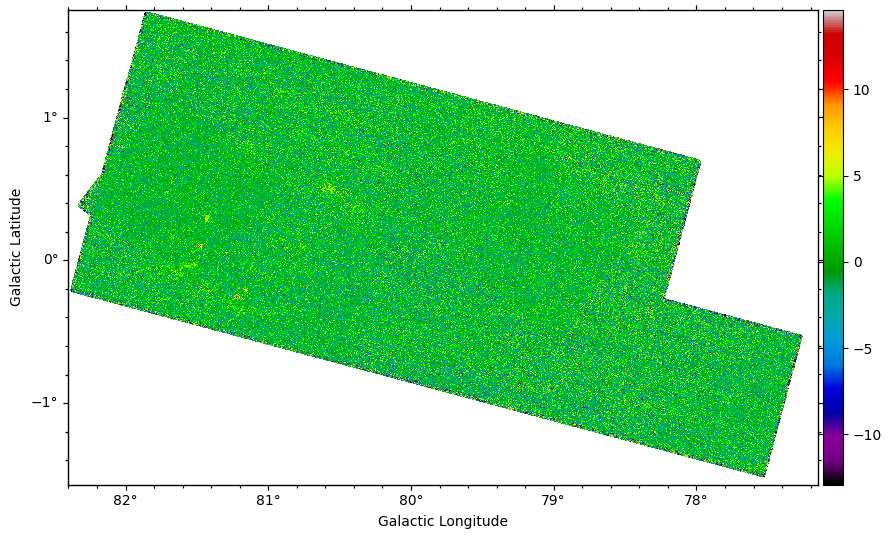

In [22]:
fig=aplpy.FITSFigure(glon_cygnus, slices=[100])
fig.show_colorscale(cmap='nipy_spectral',stretch='linear')
fig.add_colorbar()
fig.add_beam(color='k')
fig.colorbar.set_axis_label_text("[ K ]")
fig.colorbar.set_axis_label_font(size=15)
# fig.add_scalebar(length=(2000.0/3600)/43,label='2$\,$kpc',linewidth=1.,color='black',corner="bottom left")
# fig.recenter(143.042,21.504,width=0.0715103,height=0.0943856)  #degrees
fig.tick_labels.set_font(size=12) 
fig.ticks.set_color("black")
# fig.add_label(0.15,0.95,"",relative=True,color='black',family="serif",size=20)